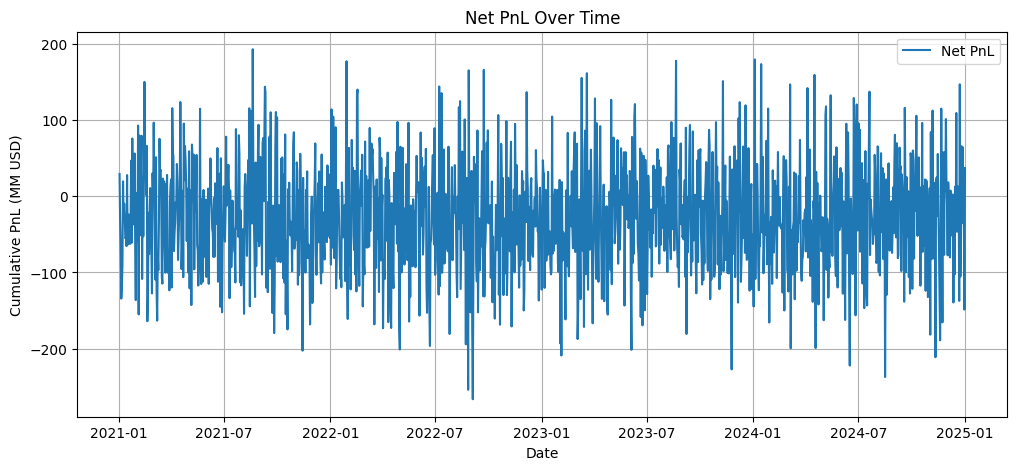

           Signal     Net PnL
2024-12-23    BUY  284.485827
2024-12-24   SELL -252.490595
2024-12-25    BUY   39.859968
2024-12-26    BUY  131.319786
2024-12-27   SELL  -31.827684
2024-12-28    BUY   30.567956
2024-12-29   SELL -100.088932
2024-12-30    BUY   20.072376
2024-12-31   SELL -133.356777
2025-01-01    BUY  185.918597


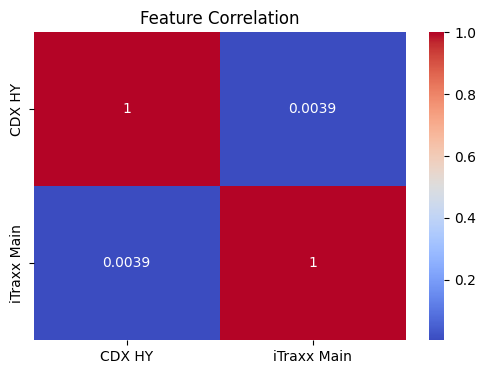

Best Combo: ('CDX HY', 'iTraxx Main')
Weights: [1. 1.]
Hedge Notionals (MM): {'CDX HY': 10.0, 'iTraxx Main': 10.0}


,CDX IG,CDX HY,iTraxx Main,iTraxx Xover
2021-01-01,97.909767,100.917525,93.137209,90.785490
2021-01-02,91.494795,102.522404,85.673287,94.346070
2021-01-03,94.194766,98.837710,101.458365,102.431347
2021-01-04,105.885784,102.147132,105.852994,95.297967
2021-01-05,116.699045,115.781181,105.148836,106.123322
...,...,...,...,...
2024-12-28,112.958718,101.761898,78.760524,69.553435
2024-12-29,92.811676,93.331513,107.209970,110.216352
2024-12-30,107.450053,101.979167,94.548138,114.363680
2024-12-31,98.053027,93.925277,129.272701,89.498135


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize

# ------------------------------
# Configuration & Sample Data
# ------------------------------

TICKERS = ['CDX IG', 'CDX HY', 'iTraxx Main', 'iTraxx Xover']
COUPON_RATES = {'CDX IG': 100, 'CDX HY': 500, 'iTraxx Main': 100, 'iTraxx Xover': 500}
CS01_LIMITS = {'CDX IG': 0.25, 'CDX HY': 0.10, 'iTraxx Main': 0.25, 'iTraxx Xover': 0.10}  # in millions
NOTIONAL = 10  # in millions
FREQ = 'D'  # Change to 'W-FRI' for weekly analytics

np.random.seed(42)
dates = pd.date_range('2021-01-01', '2025-01-01', freq=FREQ)

# Simulate desk PnL and CDS spreads
desk_pnl = pd.Series(np.random.normal(0, 0.01 if FREQ == 'D' else 0.05, len(dates)), index=dates)
cds_data = pd.DataFrame({ticker: np.random.normal(100, 10, len(dates)) for ticker in TICKERS}, index=dates)

# ------------------------------
# Utility Functions
# ------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
import streamlit as st

# ------------------------------
# Utility Functions
# ------------------------------

def calculate_cs01(spread, notional, duration=5):
    return notional * duration * 0.0001

def train_pnl_model(features, target):
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    return model

def train_signal_model(features, hedge_pnl):
    signal = hedge_pnl.apply(lambda x: 1 if x > 0.005 else (-1 if x < -0.005 else 0))
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(features, signal)
    return model

def optimize_hedge(expected_pnl, spreads, cs01_values, cs01_limits, tickers, freq, notional, coupon_rates):
    roll_multiplier = 0.2 / 252 if freq == 'D' else 0.2 / 52
    coupon_multiplier = 1/252 if freq == 'D' else 1/52

    roll_cost = roll_multiplier * spreads.values * notional * 0.0001
    coupon_cost = np.array([coupon_rates[t] * notional * coupon_multiplier * 0.0001 for t in tickers])
    total_cost = roll_cost + coupon_cost

    def objective(weights):
        return -np.dot(weights, expected_pnl - total_cost)

    constraints = [{'type': 'ineq', 'fun': lambda w, i=i: cs01_limits[i] - abs(w[i]) * cs01_values[i]} 
                   for i in range(len(expected_pnl))]
    bounds = [(-1, 1) for _ in expected_pnl]
    initial_guess = np.zeros(len(expected_pnl))

    result = minimize(objective, initial_guess, bounds=bounds, constraints=constraints)
    return result.x if result.success else np.zeros(len(expected_pnl))

def run_model(desk_pnl, cds_data, notional, freq, coupon_rates, cs01_limits):
    TICKERS = cds_data.columns.tolist()
    features = cds_data.diff().dropna()
    desk_pnl = desk_pnl[features.index]
    pnl_model = train_pnl_model(features, desk_pnl)
    predicted_pnl = pd.Series(pnl_model.predict(features), index=features.index)

    results = []
    for combo in combinations(TICKERS, 2):
        sub_features = features[list(combo)]
        hedge_pnl = -sub_features * notional * 0.5
        avg_hedge_pnl = hedge_pnl.mean().values
        latest_spreads = cds_data.iloc[-1][list(combo)]
        cs01_vals = [calculate_cs01(latest_spreads[t], notional) for t in combo]
        cs01_lims = [cs01_limits[t] for t in combo]
        weights = optimize_hedge(avg_hedge_pnl, latest_spreads, cs01_vals, cs01_lims, combo, freq, notional, coupon_rates)

        roll_multiplier = 0.2 / 252 if freq == 'D' else 0.2 / 52
        coupon_multiplier = 1/252 if freq == 'D' else 1/52
        roll_cost = roll_multiplier * latest_spreads.values * notional * 0.0001
        coupon_cost = np.array([coupon_rates[t] * notional * coupon_multiplier * 0.0001 for t in combo])
        total_cost = roll_cost + coupon_cost

        net_pnl = predicted_pnl + hedge_pnl @ weights - (weights @ total_cost)
        sharpe = net_pnl.mean() / net_pnl.std()

        results.append({
            'combo': combo,
            'weights': weights,
            'net_pnl': net_pnl,
            'sharpe': sharpe,
            'hedge_pnl': hedge_pnl @ weights,
            'full_hedge_pnl': hedge_pnl
        })

    best = max(results, key=lambda x: x['sharpe'])
    signal_model = train_signal_model(features[list(best['combo'])], best['hedge_pnl'])
    predicted_signals = pd.Series(signal_model.predict(features[list(best['combo'])]), index=features.index)

    return {
        'combo': best['combo'],
        'weights': best['weights'],
        'net_pnl': best['net_pnl'],
        'signals': predicted_signals,
        'features': features[list(best['combo'])],
        'hedge_pnl': best['hedge_pnl'],
        'desk_pnl': desk_pnl,
        'full_hedge_pnl': best['full_hedge_pnl']
    }

# ------------------------------
# Streamlit App
# ------------------------------

def streamlit_app():
    st.set_page_config(layout="wide")
    st.title("📈 CDS Hedge Optimizer Dashboard")

    freq = st.radio("Select Frequency", ['D', 'W-FRI'], index=0)
    notional = st.slider("Notional (MM USD)", 1, 100, 10)

    tickers = ['CDX IG', 'CDX HY', 'iTraxx Main', 'iTraxx Xover']
    coupon_rates = {'CDX IG': 100, 'CDX HY': 500, 'iTraxx Main': 100, 'iTraxx Xover': 500}
    cs01_limits = {'CDX IG': 0.25, 'CDX HY': 0.10, 'iTraxx Main': 0.25, 'iTraxx Xover': 0.10}

    np.random.seed(42)
    dates = pd.date_range('2021-01-01', '2025-01-01', freq=freq)
    desk_pnl = pd.Series(np.random.normal(0, 0.01 if freq == 'D' else 0.05, len(dates)), index=dates)
    cds_data = pd.DataFrame({t: np.random.normal(100, 10, len(dates)) for t in tickers}, index=dates)

    results = run_model(desk_pnl, cds_data, notional, freq, coupon_rates, cs01_limits)

    st.subheader("Best Hedge Configuration")
    st.write(f"**Products:** {results['combo']}")
    st.write(f"**Weights:** {results['weights']}")
    st.write(f"**Hedge Notionals (MM USD):** {dict(pd.Series(results['weights'] * notional, index=results['combo']))}")

    st.subheader("Net Cumulative PnL")
    net_pnl = results['net_pnl'].cumsum()
    st.line_chart(net_pnl)

    st.subheader("Trade Signal Chart (Buy / Hold / Sell)")
    signal_plot = net_pnl.copy()
    signal_plot = pd.DataFrame({'PnL': signal_plot, 'Signal': results['signals']})
    buy = signal_plot[signal_plot['Signal'] == 1]
    sell = signal_plot[signal_plot['Signal'] == -1]
    hold = signal_plot[signal_plot['Signal'] == 0]

    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(net_pnl, label="Cumulative Net PnL", color='black')
    ax.scatter(buy.index, buy['PnL'], label='BUY', color='green', marker='^')
    ax.scatter(sell.index, sell['PnL'], label='SELL', color='red', marker='v')
    ax.scatter(hold.index, hold['PnL'], label='HOLD', color='blue', alpha=0.2, marker='o')
    ax.set_title("Buy / Hold / Sell Signals")
    ax.set_xlabel("Date")
    ax.set_ylabel("Cumulative PnL (MM USD)")
    ax.legend()
    ax.grid(True)
    st.pyplot(fig)

    st.subheader("Feature Correlation")
    fig2, ax2 = plt.subplots(figsize=(6, 4))
    sns.heatmap(results['features'].corr(), annot=True, cmap='coolwarm', ax=ax2)
    st.pyplot(fig2)

    st.subheader("Latest Signals Table")
    signal_df = pd.DataFrame({
        'Signal': results['signals'].replace({1: 'BUY', 0: 'HOLD', -1: 'SELL'}),
        'Net PnL': results['net_pnl']
    })
    st.dataframe(signal_df.tail(10))


if __name__ == "__main__":
    streamlit_app()
